In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/advanced_datamining')

In [4]:
os.listdir()

['best_mlp_model.pth',
 'best_LinearRegression_model.pkl',
 'best_GradientBoosting_model.pkl',
 'best_RandomForest_model.pkl',
 'model_training.ipynb',
 'project.ipynb',
 'test_dataset.csv',
 'train_dataset.csv',
 'yield_df.csv']

In [5]:
#Upload the best models
lr_model_path='best_LinearRegression_model.pkl'
linear_regression_model = joblib.load(lr_model_path)

rf_model_path='best_RandomForest_model.pkl'
random_forest_model = joblib.load(rf_model_path)

gb_model_path="best_GradientBoosting_model.pkl"
gradient_boosting_model = joblib.load(gb_model_path)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. Th

In [6]:
#Read test dataset
test_dataset=pd.read_csv("test_dataset.csv")
train_dataset=pd.read_csv("train_dataset.csv")

In [7]:
#Preprocess datasets
X_test = test_dataset.drop(['hg/ha_yield','Unnamed: 0'],axis=1)
y_test = test_dataset['hg/ha_yield']
categorical_columns = X_test.select_dtypes(include=['object']).columns
X_encoded_test = pd.get_dummies(X_test, columns=categorical_columns).astype(int)

In [9]:
#Make predictions
lr_predictions = linear_regression_model.predict(X_encoded_test)
rf_predictions = random_forest_model.predict(X_encoded_test)
gb_predictions = gradient_boosting_model.predict(X_encoded_test)

In [10]:
class MLPRegressor(nn.Module):
    def __init__(self, trial):
        super(MLPRegressor, self).__init__()
        n_layers = trial.suggest_int('n_layers', 1, 3)
        layers = []
        in_features = X_train.shape[1]

        for i in range(n_layers):
            out_features = trial.suggest_int(f'n_units_l{i}', 4, 128)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            p = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
            layers.append(nn.Dropout(p))
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
loaded_model= torch.load('best_mlp_model.pth')
loaded_model.eval()

X_val_tensor = torch.tensor(X_encoded_test.values, dtype=torch.float32)

# Make predictions
with torch.no_grad():  # Disable gradients during inference
    mlp_predictions = loaded_model(X_val_tensor).numpy()

<ipython-input-11-58ac005a3dd7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model= torch.load('best_mlp_model.pth')


In [12]:
# Evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Dictionary to store models and their predictions
models_predictions = {
    "Linear Regression": lr_predictions,
    "Random Forest": rf_predictions,
    "Gradient Boosting": gb_predictions,
    "MLP": mlp_predictions
}

# Loop through each model and print its evaluation metrics
for model_name, predictions in models_predictions.items():
    mae, mse, rmse, r2 = evaluate_model(y_test, predictions)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}\n")

Linear Regression Performance:
MAE: 29582.248317304555
MSE: 1776123394.0610187
RMSE: 42144.078991728114
R²: 0.7551414785235807

Random Forest Performance:
MAE: 4355.662400139181
MSE: 103048241.46007657
RMSE: 10151.267973020738
R²: 0.9857936446707303

Gradient Boosting Performance:
MAE: 26397.412980217494
MSE: 1423951341.4559717
RMSE: 37735.27979829978
R²: 0.8036923440740995

MLP Performance:
MAE: 58283.23862353957
MSE: 7795765323.90441
RMSE: 88293.63127601227
R²: -0.07473373413085938



# Do training from scratch with feature scaling

In [13]:
X_train = train_dataset.drop(['hg/ha_yield','Unnamed: 0'],axis=1)
y_train = train_dataset['hg/ha_yield']
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_encoded_train = pd.get_dummies(X_train, columns=categorical_columns).astype(int)

scaler = MinMaxScaler()

X_scaled_train = scaler.fit_transform(X_encoded_train)
X_scaled_test = scaler.transform(X_encoded_test)

# Evaluation per model using a plot and metrics

Training Decision Tree...


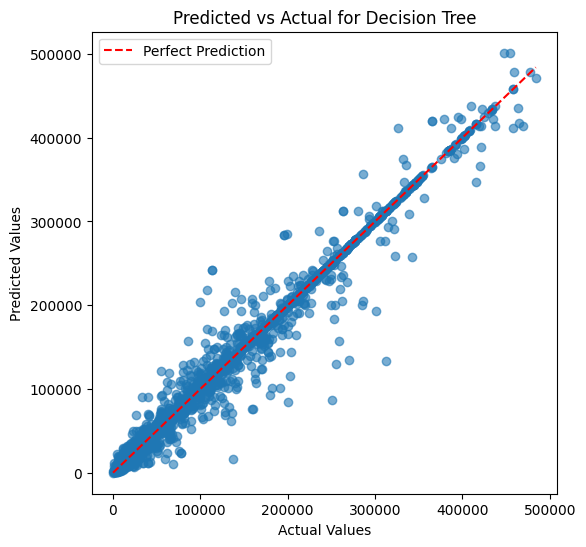

Training Random Forest...


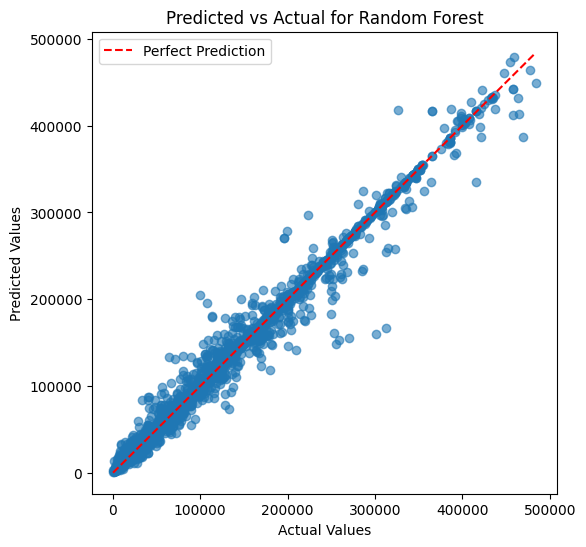

Training Gradient Boosting...


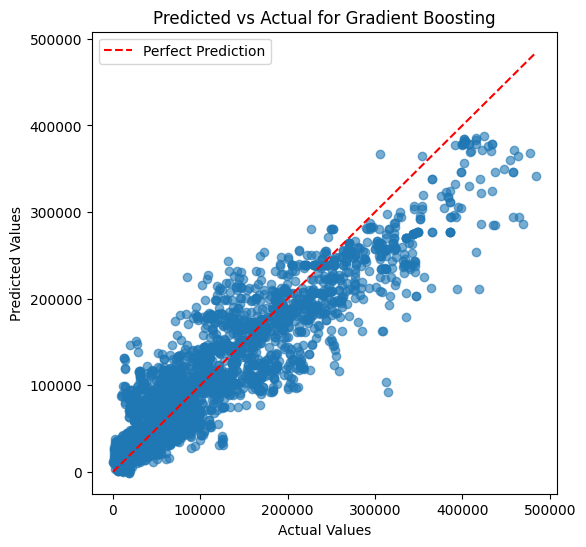

Training MLP...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


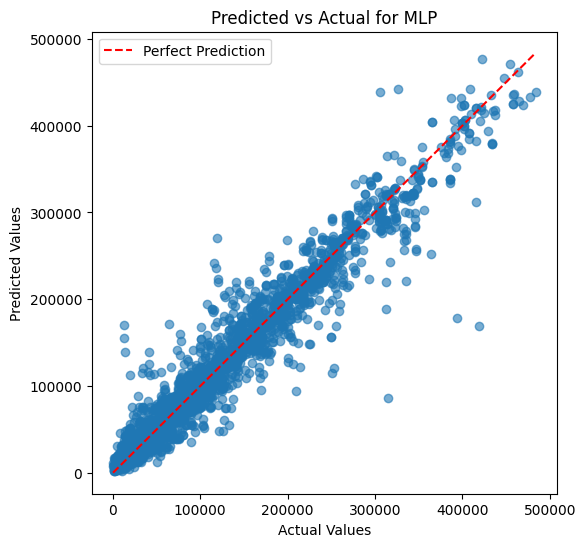

Training SVR...


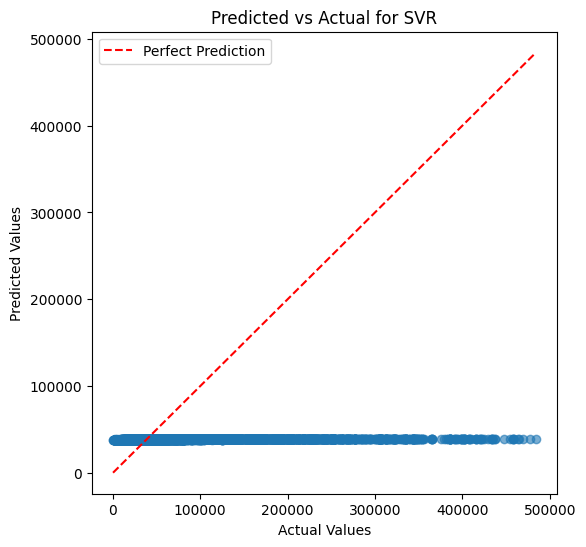


Decision Tree Performance on Test Data:
MAE: 3211.808461674633
MSE: 118666068.03186405
RMSE: 10893.395615319589
R²: 0.9836405521908776

Random Forest Performance on Test Data:
MAE: 3157.243281996814
MSE: 80268650.59846926
RMSE: 8959.27734800465
R²: 0.9889340666464004

Gradient Boosting Performance on Test Data:
MAE: 19463.511686558362
MSE: 919735327.8095695
RMSE: 30327.13847051135
R²: 0.8732041741749931

MLP Performance on Test Data:
MAE: 9100.570723676368
MSE: 292920801.0101667
RMSE: 17114.929185076013
R²: 0.9596175837304614

SVR Performance on Test Data:
MAE: 56992.823608443854
MSE: 8673029026.095285
RMSE: 93129.09870762889
R²: -0.1956742820644375


In [14]:
from sklearn.neural_network import MLPRegressor as MLP_py
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP': MLP_py(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    'SVR': SVR()
}

# Dictionary to store evaluation results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_scaled_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_scaled_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Store results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

    # Predicted vs Actual plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, predictions, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual for {name}')
    plt.legend()
    plt.show()


# Display evaluation results
for name, metrics in results.items():
    print(f"\n{name} Performance on Test Data:")
    print(f"MAE: {metrics['MAE']}")
    print(f"MSE: {metrics['MSE']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"R²: {metrics['R²']}")